## Key take-aways

Key take-aways of my examples should be:
* Operations in image processing are often independent across pixel. Therefore they map well to GPU.
* Memory transfer from CPU to GPU takes time.
* There are four different types of memory on the GPU:
  * global memory
  * constant memory
  * shared memory
  * texture memory with sampling

## Image convolution for edge detection

Convolution is a central operation in image processing, where the image is filtered with a kernel (also called filter or convolution matrix).
Depending on the kernel that is used, we can e.g. blur or sharpen the images or detect edges.

Here is an example of edge detection using the Sobel filter:

<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg"> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Bikesgraygv.jpg"> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/8/8a/Bikesgraygh.jpg"> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Bikesgraysobel.jpg"> </td>
</tr></table>
Original image, Sobel-V filter (vertical edges), Sobel-H filter (horizontal edges), Combined gradient

Here we used the Sobel-V filter to detect vertical edges in an image. The operation is defined as

![image](https://drive.google.com/uc?id=1mrNouszmImKHffWm1ofe_CLE_w3Zk2gi),

where the Sobel filter S<sub>x</sub> in x-direction is convolved with the image A resulting in the approximate gradient G<sub>x</sub> in x-direction. Moreover, one can calculate the gradient in vertical direction as well

![image](https://drive.google.com/uc?id=1WEjlzKRkUz7_wtK2vtvJ-hQRxYnYpdto)

and obtain the magnitude of the gradient at each pixel as:

![image](https://drive.google.com/uc?id=1zJvuAuoEy--Qy1feuyZQOnvx2o6pd689)

Generally, the discrete convolution is computed as

![image](https://drive.google.com/uc?id=1aqzIZpTqctMSl2r8UattdRGU8yiuvmol)

where K(s,t) is the kernel, I(x,y) is the original and image I<sub>new</sub>(x,y) is the resulting filtered image. In our case, for the Sobel-filter K has shape 3x3.  Each pixel in I<sub>new</sub>(x,y) is the result of the sum over all neighborhood-pixels multiplied (weighted) with its corresponding filter value.

Example of an uniform filter, which smooths the image:

![image](https://drive.google.com/uc?id=1wSFCO4WvAyjkE1Ac3dry9WbqusoGfzTi)

Since the final pixel value in depends only on its neighborhood and the (fixed) values in the kernel, this operation can be run in *parallel* for each pixel.

Note that for a MxM image and NxN filter (with uneven N) we can only compute output pixel-values within the area M-(N-1)/2 x M-(N-1)/2 of the input image. This is because the pixels in the (N-1)/2 border regions do not have enough neighboring pixels to perform the filter-operation.


Sources:
[1](https://www.sciencedirect.com/topics/computer-science/linear-convolution)
[2](https://en.wikipedia.org/wiki/Sobel_operator)

In [ ]:
!nvidia-smi

Mon Jan 18 22:37:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Define support functions and image-URL

In [ ]:
import functools
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io


""" URL of the image that we will process below """
image_path = "https://homepages.cae.wisc.edu/~ece533/images/cameraman.tif"


def read_image(image_path, tiles_per_dimension=1):
    """
    read and normalized image and return image
    with tiles_per_dimension tiles per dimension
    """
    
    image = io.imread(image_path).astype(np.float32)
    image -= np.min(image)
    image /= np.max(image)
    image = np.tile(image, (tiles_per_dimension, tiles_per_dimension))
    return image


def keep_valid_image(filtered_image, filter):
    """
    using the filter-size determined from filter array
    and the size of the filtered image return only valid area
    of the filtered image.
    """
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2
    return filtered_image[filter_height_halved:-filter_height_halved,
                         filter_width_halved:-filter_width_halved]


def show_image(image_orig, image_filtered):
    """
    show original image and filtered image side-by-side
    """
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    axes[0].imshow(image_orig, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[1].imshow(image_filtered, cmap=plt.cm.gray)
    axes[1].set_title('Processed')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def get_blocks_per_grid(threads_per_block, image_shape):
    """
    get the number of blocks per x-/y-dimension depending
    on number of pixels per dimension (image_shape) and
    and the number of threads in a block (threads_per_block)
    """
    image_shape = np.max(image_shape)  # since our image has roughly square shape: (539, 540), we do choose same size for both dimensions; we could be smarter about this
    blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
    return (blocks_per_grid_x, blocks_per_grid_y)


def print_min_and_max_pixel_vals(image):
    """
    return minimal and maximal values in the image.
    we use this below as a sanity-test that the filter results
    is same between implementations
    """
    print("min. pixel value: " + str(np.min(image)))
    print("max. pixel value: " + str(np.max(image)))


from contextlib import contextmanager
@contextmanager
def timeit_context(name, repeats=1):
    """
    context function for timing the execution time of implementations
    """
    startTime = time.time()
    for ind in range(repeats):
        yield
    elapsedTime = time.time() - startTime
    print(f"{name} is {elapsedTime * 1000./repeats:.2f} ms")

### Scikit-image Sobel-v filter (corresponding to S<sub>x</sub> from the equations above)

[Scikit-image](https://scikit-image.org/) is versatile and widely used toolbox for image processing in Python.

Let's see how to calculate the Sobel-V filter using it. The corresponding function is called `sobel_v`, because it detectes *vertical* edges.

It corresponds to a normalized version of the S<sub>x</sub> operator shown above.

Scikit-Image CPU execution time is 0.79 ms
min. pixel value: -0.89634144
max. pixel value: 0.9146341


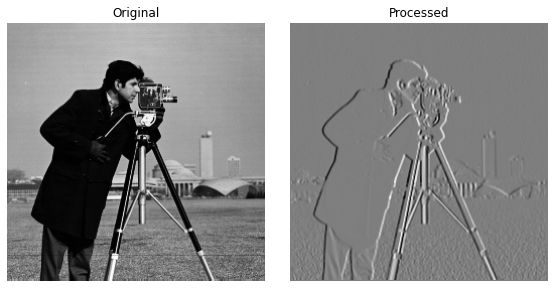

In [ ]:
image = read_image(image_path)

# filter vertical edges with sobel_v
with timeit_context('Scikit-Image CPU execution time'):
    edges_sobel_v = filters.sobel_v(image)

# print min- and max-values for comparison with reference implementation
print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

### Custom CPU implementation

Here is a custom CPU version of the convolution function using Numba JIT.

In [ ]:
from numba import jit

# CPU convolution definition
@jit(nopython=True)
def filter2d_cpu_jit(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    for row in range(0, image_height):  # iterate over pixel rows
        for col in range(0, image_width):  # iterate over pixel columns
            if (row > filter_height_halved and row < image_height - filter_height_halved):  # stay within valid area of the image
                if (col > filter_width_halved and col < image_width - filter_width_halved):  # stay within valid area of the image
                    sum = 0.0
                    for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                        for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                            kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                            imageCoord = row + conv_index_y, col + conv_index_x
                            sum += filt[kernelCoord] * image[imageCoord]
                    result[row, col] = sum

In [ ]:
from numba import jit, njit, prange

# CPU convolution definition
@njit(parallel=True)
def filter2d_cpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    for row in prange(0, image_height):  # iterate over pixel rows
        for col in prange(0, image_width):  # iterate over pixel columns
            if (row > filter_height_halved and row < image_height - filter_height_halved):  # stay within valid area of the image
                if (col > filter_width_halved and col < image_width - filter_width_halved):  # stay within valid area of the image
                    sum = 0.0
                    for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                        for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                            kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                            imageCoord = row + conv_index_y, col + conv_index_x
                            sum += filt[kernelCoord] * image[imageCoord]
                    result[row, col] = sum

CPU execution time with filter2d_cpu_jit is 101.88 ms
CPU execution time with filter2d_cpu is 98.37 ms
min. pixel value: -0.89634144
max. pixel value: 0.9146341


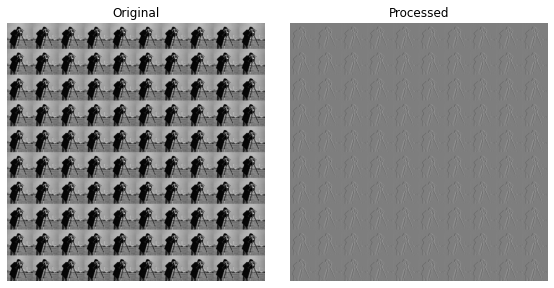

In [ ]:
import numpy as np

# read image and define output image
image = read_image(image_path, 10)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# filter image
with timeit_context('CPU execution time with filter2d_cpu_jit'):
    filter2d_cpu_jit(image, sobel_v_filter, edges_sobel_v)

with timeit_context('CPU execution time with filter2d_cpu'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# strip invalid image regions and show
edges_sobel_v = keep_valid_image(edges_sobel_v, sobel_v_filter)

print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

Same result as Scikit-Image. Now let's rewrite the convolution function to get a naive CUDA kernel.

# Naive CUDA implementation

### Now let's rewrite that function as a CUDA kernel and compare its performance.

In [ ]:
from numba import cuda

# kernel definition
@cuda.jit
def filter2d_gpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += filt[kernelCoord] * image[imageCoord]
            result[row, col] = sum

CPU execution time is 1.01 ms
GPU execution time is 2.60 ms
min. pixel value: -0.89634144
max. pixel value: 0.9146341


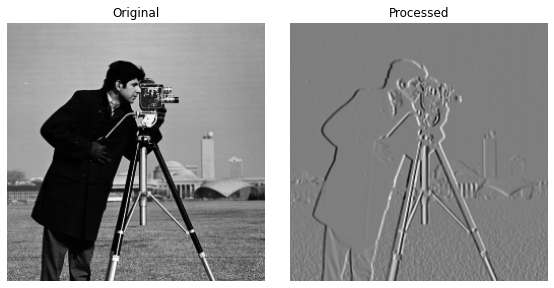

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 1)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

filter_height, filter_width = sobel_v_filter.shape
filter_height_halved = filter_height // 2
filter_width_halved = filter_width // 2

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# resCPU = %timeit -n 2 -r 10 -o filter2d_cpu(image, sobel_v_filter, edges_sobel_v)
with timeit_context('CPU execution time'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# resGPU = %timeit -n 2 -r 10 -o filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
with timeit_context('GPU execution time'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)

# strip invalid image regions and show
edges_sobel_v = keep_valid_image(edges_sobel_v, sobel_v_filter)

print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

GPU is *slower* than CPU. But what happens for larger images? Let's try with 10x10 tiling of the image ...

CPU execution time is 103.61 ms
GPU execution time is 27.01 ms
min. pixel value: -0.89634144
max. pixel value: 0.9146341


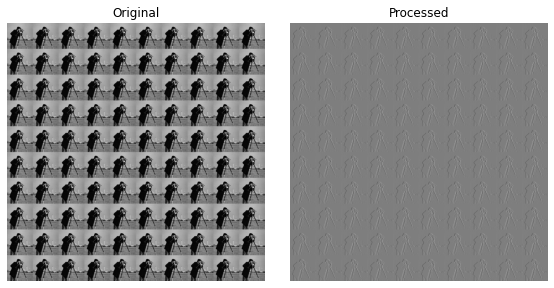

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 10)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# filter vertical edges with sobel_v_filter

# resCPU = %timeit -n 2 -r 10 -o filter2d_cpu(image, sobel_v_filter, edges_sobel_v)
with timeit_context('CPU execution time'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# resGPU = %timeit -n 2 -r 10 -o filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
with timeit_context('GPU execution time'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
    cuda.synchronize()

print_min_and_max_pixel_vals(edges_sobel_v)
    
show_image(image, edges_sobel_v)

Now GPU is faster. The missing speed-up in the previous example is due to memory transfer to the GPU.
Let's look at the time spent on data transfer and GPU computation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 10)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# filter_height, filter_width = sobel_v_filter.shape
# filter_height_halved = filter_height // 2
# filter_width_halved = filter_width // 2

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

with timeit_context('GPU time including transfer'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
    cuda.synchronize()

print("")

# copy to arrays to device memory before processing
stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(sobel_v_filter, stream=stream)
    filtered_image_on_device = cuda.to_device(edges_sobel_v, stream=stream)
    cuda.synchronize()

with timeit_context('GPU processing time without transfer'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
    cuda.synchronize()

# get arrays from device memory before processing
with timeit_context('Transfer time from GPU'):
    image_on_host = image_on_device.copy_to_host()
    filter_on_host = filter_on_device.copy_to_host()
    filtered_image_on_host = filtered_image_on_device.copy_to_host()
    cuda.synchronize()

print("")
print_min_and_max_pixel_vals(edges_sobel_v)

GPU time including transfer is 27.35 ms

Transfer time to GPU is 19.80 ms
GPU processing time without transfer is 3.48 ms
Transfer time from GPU is 11.96 ms

min. pixel value: -0.89634144
max. pixel value: 0.9146341


So we spend much time with transfering the data to the GPU.

Conclusions:

1. A workload must be sufficiently large in order for the speed-up on GPU to justify the time spent on data transfer.
2. For computations consisting of multiple CUDA kernels, we should try to keep processed data in GPU memory as long possible and avoid unnecessary data-transfer.
3. We can transfer data to the GPU asynchronously with other/running computations to hide memory transfer time.(???)

----

## CUDA kernel with constant memory

Now let's improve performance by using constant memory of the GPU:
Constant memory is a small cache (e.g. ~64kB) that is accessible from all threads and faster than global memory.
It is assigned from the host to the GPU and unaltered during kernel execution. It is a good fit for our filter-array, which stays constant during processing.

Links on using constant memory in numba.cuda:
* https://stackoverflow.com/questions/63311574/in-numba-how-to-copy-an-array-into-constant-memory-when-targeting-cuda
* https://github.com/numba/numba/issues/4057
* Link on memory in GPU: https://www.paranumal.com/single-post/2018/02/26/basic-gpu-optimization-strategies

In [ ]:
from numba import cuda

# filter array needs to be defined on host
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# kernel definition
@cuda.jit
def filter2d_gpu_with_const_filter(image, result):
    const_filter = cuda.const.array_like(sobel_v_filter)  # assignment of host-memory/filter as constant memory on GPU

    image_height, image_width = image.shape
    filter_height, filter_width = const_filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += const_filter[kernelCoord] * image[imageCoord]
            result[row, col] = sum

GPU processing time without constant memory is 8.28 ms
GPU processing time with constant memory is 8.24 ms

min. pixel value: -0.89634144
max. pixel value: 0.9146341


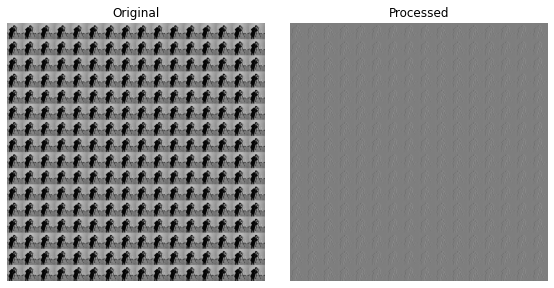

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 16)
edges_sobel_v = np.zeros_like(image)

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# copy to arrays to device memory before processing
stream = cuda.stream()
# with timeit_context('Transfer to GPU'):
image_on_device = cuda.to_device(image, stream=stream)
filter_on_device = cuda.to_device(sobel_v_filter, stream=stream)
filtered_image_on_device = cuda.to_device(edges_sobel_v, stream=stream)
cuda.synchronize()

with timeit_context('GPU processing time without constant memory'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
    cuda.synchronize()

with timeit_context('GPU processing time with constant memory'):
    filter2d_gpu_with_const_filter[blocks_per_grid, threads_per_block](image_on_device, filtered_image_on_device)
    cuda.synchronize()

edges_sobel_v = filtered_image_on_device.copy_to_host()
cuda.synchronize()

print("")
print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

### CUDA kernel using shared memory

Global memory is the slowest memory on the GPU. In our current implementation each thread is accessing global memory separately to obtain its respective pixel and neighborhood. Since the neighborhoods of adjacent pixels overlap, we can optimize the access to global memory by first copying all relevant pixels of the block to the local memory and use local memory for the processing.
This is shown in the following example.

In [ ]:
from numba import cuda, float32
import numpy as np

# filter array needs to be defined on host
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

group_size = 16

# kernel definition with local memory:
# * local memory size needs to be known before kernel instantiation
# * size is TBP pluss fitler-size, since we need the edges around the block-area for convolution
filter_size = filter_height
filter_size_halved = filter_size // 2
shared_memory_size = group_size + 2 * filter_size_halved

@cuda.jit
def filter2d_gpu_with_const_filter_and_local_memory(image, result):
    const_filter = cuda.const.array_like(sobel_v_filter)  # assignment of host-memory/filter as constant memory on GPU

    image_height, image_width = image.shape
    filter_height, filter_width = const_filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2
    filter_size_halved = filter_height_halved

    # localRowOffset = filter_size_halved
    # localColOffset = filter_size_halved

    # Define an array in the shared memory
    shared_memory = cuda.shared.array(shape=(shared_memory_size, shared_memory_size), dtype=float32)

    # row_alt, col_alt = cuda.grid(2)

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    local_row = cuda.threadIdx.y
    local_col = cuda.threadIdx.x
    local_row_offset = local_row + filter_size_halved
    local_col_offset = local_col + filter_size_halved

    # Check that thread-index lies within image
    if  row >  image_height or\
        col > image_width:
        cuda.syncthreads()
        return

    # copy pixels inside group-area of image
    shared_memory[local_row_offset, local_col_offset] =\
        image[row, col]

    # if pixel index is not within valid convolution bounds for image, then do nothing but sync
    if  row <= filter_size_halved or\
        row >= image_height - filter_size_halved or\
        col <= filter_size_halved or\
        col >= image_width - filter_size_halved:

        cuda.syncthreads()
        return

    # copy additional pixels (needed for convolution), if thread sits inside group-border of width filter_width_halved or height filter_height_halved
    if local_row <= filter_size_halved:
        shared_memory[local_row_offset - filter_size_halved, local_col_offset] = image[row - filter_size_halved, col]

    elif local_row > group_size - filter_size_halved:
        shared_memory[local_row_offset, local_col_offset] = image[row + filter_size_halved, col]

    if local_col <= filter_size_halved: # handle left convolution neighborhood
        shared_memory[local_row_offset, local_col_offset - filter_size_halved] =\
            image[row, col - filter_size_halved]
        if local_row <= filter_size_halved:  # copy also top-left corner
            shared_memory[local_row_offset - filter_size_halved, local_col_offset - filter_size_halved] =\
                image[row - filter_size_halved, col - filter_size_halved]
        elif local_row > group_size - filter_size_halved:  # copy also bottom-left corner
            shared_memory[local_row_offset, local_col_offset - filter_size_halved] =\
                image[row + filter_size_halved, col - filter_size_halved]
    elif local_col > group_size - filter_size_halved: # handle right convolution neighborhood
        shared_memory[local_row_offset, local_col_offset] =\
            image[row, col + filter_size_halved]
        if local_row <= filter_size_halved:  # copy also top-right corner
            shared_memory[local_row_offset - filter_size_halved, local_col_offset] =\
                image[row - filter_size_halved, col + filter_size_halved]
        elif local_row > group_size - filter_size_halved:  # copy also bottom-right corner
            shared_memory[local_row_offset - filter_size_halved, local_col_offset] =\
                image[row + filter_size_halved, col + filter_size_halved]

    cuda.syncthreads()

    sum = 0.0
    for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
        for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
            kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
            imageCoord = local_row + conv_index_y, local_col + conv_index_x
            sum += const_filter[kernelCoord] * shared_memory[imageCoord]
    result[row, col] = sum

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 1)
edges_sobel_v = np.zeros_like(image)

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# copy to arrays to device memory before processing
stream = cuda.stream()
# with timeit_context('Transfer to GPU'):
image_on_device = cuda.to_device(image, stream=stream)
filter_on_device = cuda.to_device(sobel_v_filter, stream=stream)
filtered_image_on_device = cuda.to_device(edges_sobel_v, stream=stream)
cuda.synchronize()

with timeit_context('GPU time with constant memory'):
    filter2d_gpu_with_const_filter[blocks_per_grid, threads_per_block](image_on_device, filtered_image_on_device)
    cuda.synchronize()

with timeit_context('GPU time without constant memory and shared memory'):
    filter2d_gpu_with_const_filter_and_local_memory[blocks_per_grid, threads_per_block](image_on_device, filtered_image_on_device)
    cuda.synchronize()

edges_sobel_v = filtered_image_on_device.copy_to_host()
cuda.synchronize()

show_image(image, edges_sobel_v)


print("")
print_min_and_max_pixel_vals(edges_sobel_v)

GPU time with constant memory is 0.47 ms


Resources:
* [A study of OpenCL image
convolution optimization](https://www.evl.uic.edu/kreda/gpu/image-convolution/)
* [Discussion of different types of memory](https://www.microway.com/hpc-tech-tips/gpu-memory-types-performance-comparison/)